# The Second Goal For Today!

Understand how PCA can influence naive Bayes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy

# Load and Look at Your Data

The data set we wil be analyzing is the dataset of car logos from https://github.com/GeneralBlockchain/vehicle-logos-dataset. I converted each logo to greyscale and downscaled them to a consistent size. I also converted the dependent variable (manufacturer name) to an int; it is the last column.

First we load the data.

In [2]:
# load the data
data = np.array(np.genfromtxt('data/logos.csv', delimiter=',', dtype=int))  

Then we get summary statistics.

In [3]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
         0           1           2           3           4           5     \
0    1.000000    0.000000    0.000000    1.000000    0.000000    0.000000   
1  255.000000  255.000000  255.000000  255.000000  255.000000  255.000000   
2   98.911765   98.702206   99.128676   99.816176  100.176471  100.419118   
3   73.030636   73.085588   72.546752   71.361312   70.269872   69.468524   

         6           7           8           9     ...        1015  \
0    0.000000    0.000000    0.000000    0.000000  ...    0.000000   
1  255.000000  255.000000  255.000000  255.000000  ...  255.000000   
2  101.363971  103.575368  105.222426  106.459559  ...   83.446691   
3   68.542386   69.028033   70.360052   70.067865  ...   64.160020   

         1016        1017        1018        1019        1020        1021  \
0    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1  255.000000  246.000000  240.000000  254.000000  255.000000  255.000000   

# Split the data

If we are doing supervised machine learning, we split the data into train and test. 

In [4]:
# shuffle the data
np.random.shuffle(data)

# split the data into train and test
(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print("train, test: ", train.shape, test.shape)

train, test:  (435, 1025) (109, 1025)


Strip off the dependent variable (the labels, the classes). Let's go with trying to predict the car's **drive train**. That's the last variable.

In [5]:
y_train = train[:, -1]
x_train = train[:, 0:-1]
y_test = test[:, -1]
x_test = test[:, 0:-1]

# PCA Review

This code for PCA comes from day 19; I just put it into functions.

This code you can use as a **tool**.

**If you are using separate training and test data, you want to project both training and test data using eigenvectors calculated on the _training data_.**

In [6]:
def prep_pca(data):
    # center data
    centered_data = data - np.mean(data, axis=0)
    # covariance matrix
    covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
    # singular value decomposition
    evals, evectors = scipy.linalg.eigh(covariance_matrix)
    # sort eigenvals, eigenvecs
    order = np.argsort(evals)[::-1]
    eigenvals_sorted = evals[order]
    eigenvecs_sorted = evectors[:, order]
    return centered_data, covariance_matrix, eigenvals_sorted, eigenvecs_sorted

def plot_covariance_matrix(covariance_matrix):
    fig = plt.figure(figsize=(12,12))
    sns.heatmap(pd.DataFrame(covariance_matrix), annot=False, cmap='PuOr')
    plt.show()

def plot_eigenvectors(eigenvecs_sorted):
    fig = plt.figure(figsize=(14,3))
    sns.heatmap(pd.DataFrame(eigenvecs_sorted[:, 0:21].T), 
                annot=False, cmap='coolwarm',
               vmin=-0.5,vmax=0.5)
    plt.ylabel("Ranked Eigenvalue")
    plt.xlabel("Eigenvector Components")
    plt.show()

def get_proportional_variances(eigenvals_sorted):
    sum = np.sum(eigenvals_sorted)
    proportional_variances = np.array([eigenvalue / sum for eigenvalue in eigenvals_sorted])
    cumulative_sum = np.cumsum(proportional_variances)
    return proportional_variances, cumulative_sum

def scree_graph(proportional_variances):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(proportional_variances)), proportional_variances, alpha=0.5, align='center',
            label='Proportional variance')
    plt.ylabel('Proportional variance ratio')
    plt.xlabel('Ranked Principal Components')
    plt.title("Scree Graph")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def elbow_plot(cumulative_sum):
    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.plot(cumulative_sum)
    ax1.set_ylim([0,1.0])
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_title('Elbow Plot')
    plt.show()

def fit_pca(centered_data, eigenvecs_sorted, number_to_keep):
    v = eigenvecs_sorted[:, :number_to_keep]
    projected_data = centered_data@v
    return projected_data

Let's try it!

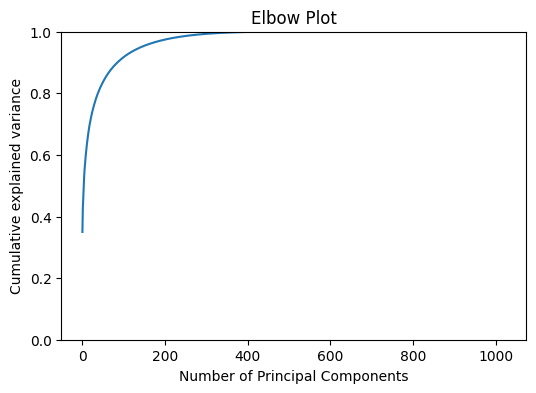

In [7]:
centered_train, covariance_matrix, eigenvals_sorted, eigenvecs_sorted = prep_pca(x_train)
proportional_variances, cumulative_sum = get_proportional_variances(eigenvals_sorted)
elbow_plot(cumulative_sum)

In [8]:
projected_train = fit_pca(centered_train, eigenvecs_sorted, 200)
centered_test = x_test - np.mean(x_train, axis=0)
projected_test = fit_pca(centered_test, eigenvecs_sorted, 200)

# Naive Bayes with and without PCA first

The independent variables for this dataset are quantitative, so we can't use the very naive implementation of naive Bayes we've just made. Instead, I'm going to use a Gaussian NB implementation from scikit-learn, which can handle independent variables that are quantitative.

But first, I copy over the definition of accuracy from day 24.

In [9]:

from sklearn.naive_bayes import GaussianNB

def accuracy(y, yhat):
    assert len(y) == len(yhat)
    diffs = y == yhat
    vals, counts = np.unique(diffs, return_counts=True)
    return counts[np.where(vals == True)] / (np.sum(counts))

## NB without PCA

In [10]:
%%time

gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

print(accuracy(y_test, y_pred))

[0.53211009]
CPU times: user 19.9 ms, sys: 7.97 ms, total: 27.9 ms
Wall time: 27.8 ms


## NB with PCA

In [11]:
%%time

gnb = GaussianNB()
y_pred = gnb.fit(projected_train, y_train).predict(projected_test)

print(accuracy(y_test, y_pred))

[0.74311927]
CPU times: user 6.51 ms, sys: 3.61 ms, total: 10.1 ms
Wall time: 9.79 ms


So indeed, PCA can make a difference in speed and accuracy!